In [13]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_curve, auc, classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier, plot_importance


# Standard Trees

In [6]:
# Load and Setup data for processing

df = pd.read_csv('data.csv')
df['REASON'] = df['REASON'].replace(np.nan, 'NotProvided')
df['JOB'] = df['JOB'].replace(np.nan, 'Other')
mean_fill_cols = ['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'NINQ', 'CLNO', 'DEBTINC']
lin_reg_cols = ['VALUE']

In [7]:
# Function used to find the best Pruned Tree

def prune_tree(train_X, train_y, test_X, test_y, aplpha_values):
    best_f1 = 0
    best_tree = None
    for alpha in aplpha_values:
        tree = DecisionTreeClassifier(random_state=8, ccp_alpha=alpha)
        tree.fit(train_X, train_y)
        
        y_pred = tree.predict(test_X)
        f1 = f1_score(y_true=test_y, y_pred=y_pred)
        
        if f1 > best_f1:
            best_f1 = f1
            best_tree = tree
    
    return best_tree

Before Pruning: precision is 0.7077625570776256, recall is 0.6540084388185654, f1 is 0.6798245614035088 Depth is 27
After Pruning: precision is 0.7536231884057971, recall is 0.6582278481012658, f1 is 0.7027027027027027 Depth is 13


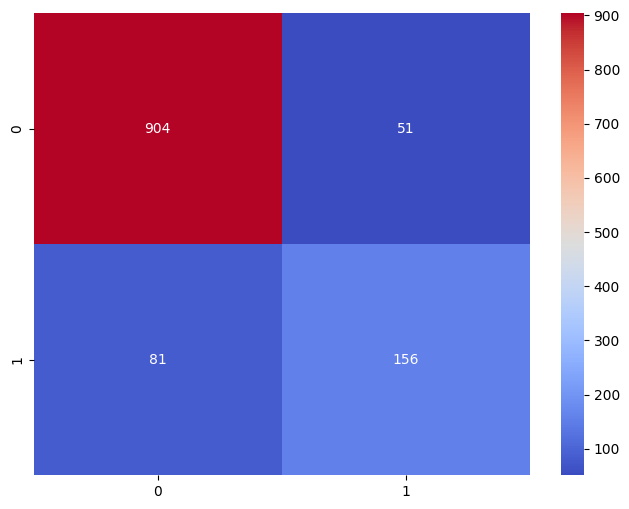

Before Pruning: precision is 0.6851851851851852, recall is 0.5826771653543307, f1 is 0.6297872340425532 Depth is 28
After Pruning: precision is 0.7393162393162394, recall is 0.6811023622047244, f1 is 0.7090163934426229 Depth is 6


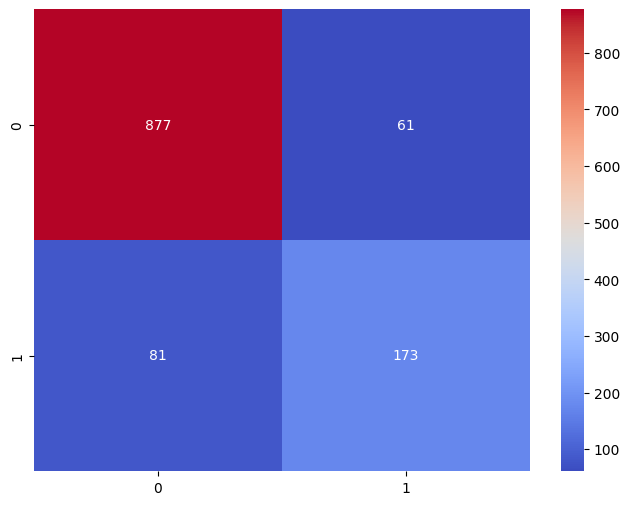

Before Pruning: precision is 0.6620370370370371, recall is 0.65, f1 is 0.6559633027522935 Depth is 32
After Pruning: precision is 0.7621359223300971, recall is 0.7136363636363636, f1 is 0.7370892018779343 Depth is 18


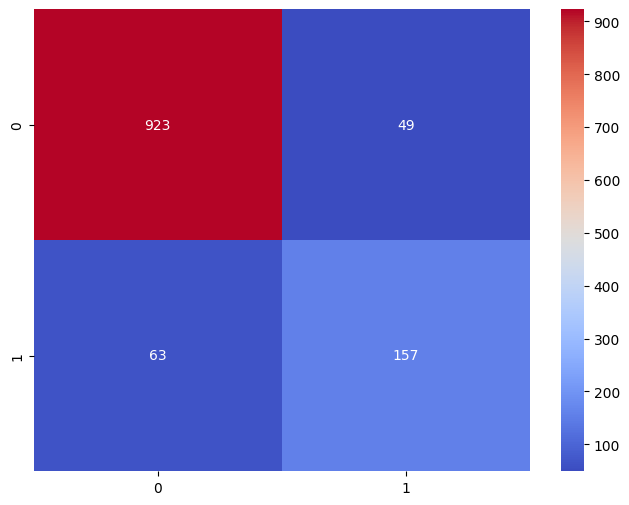

Before Pruning: precision is 0.780373831775701, recall is 0.6653386454183267, f1 is 0.7182795698924731 Depth is 34
After Pruning: precision is 0.8333333333333334, recall is 0.6573705179282868, f1 is 0.734966592427617 Depth is 22


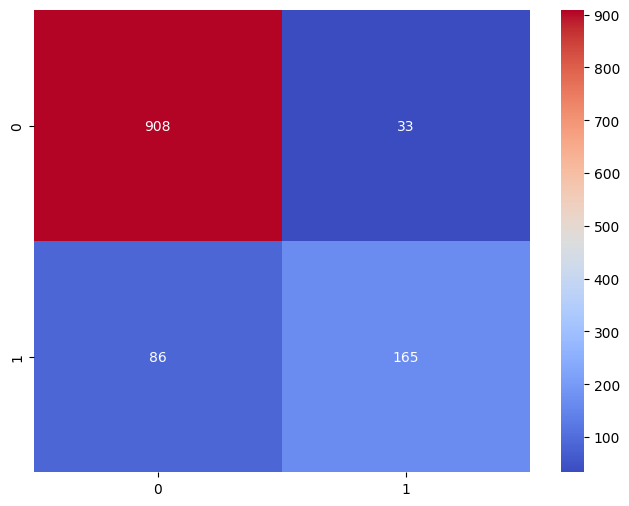

Before Pruning: precision is 0.6150627615062761, recall is 0.6475770925110133, f1 is 0.630901287553648 Depth is 29
After Pruning: precision is 0.7025862068965517, recall is 0.7180616740088106, f1 is 0.710239651416122 Depth is 13


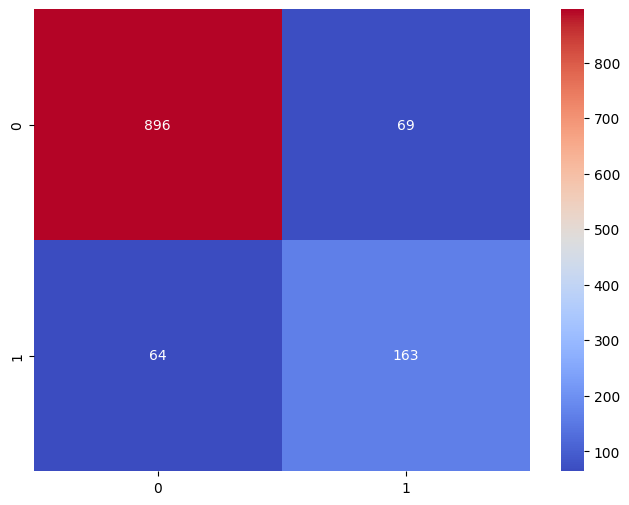

Mean precision error is 0.690084274516365 Mean recall error is 0.6399202684204471  Mean f1 error is 0.6629511911288953 Mean Depth 30.0
Prune Mean precision error is 0.7581989780564038 Mean recall error is 0.6856797531758902  Mean f1 error is 0.7188029083733999 Mean Depth 14.4


In [8]:
kf = KFold(n_splits=5, shuffle=True, random_state=7)

precision_error = []
recall_error = []
f1_error = []
depth_track = []

precision_error_prune = []
recall_error_prune = []
f1_error_prune = []
depth_track_prune = []

for train_idx, test_idx in kf.split(df):
    train_data = df.iloc[train_idx].copy()
    test_data = df.iloc[test_idx].copy()
    
    # Remove traget variable
    y_train = train_data.pop('BAD')
    y_test = test_data.pop('BAD')
    
    # Fill missing values with mean
    for col in mean_fill_cols:
        mean = train_data[col].mean()
        train_data[col] = train_data[col].fillna(mean)
        test_data[col] = test_data[col].fillna(mean)
    
    # Fill missing values using linear regression (It goes MORTDUE then VALUE as MORTDUE has more missing values)
    for col in lin_reg_cols:
        linear_train_data = train_data.copy()
        linear_test_data = test_data.copy()
        
        # fill VALUE with Mean for the first pass
        if col == 'MORTDUE':
            mean = linear_train_data['VALUE'].mean()
            linear_train_data['VALUE'] = linear_train_data['VALUE'].fillna(mean)
            linear_test_data['VALUE'] = linear_test_data['VALUE'].fillna(mean)
        
        linear_train_data = linear_train_data.dropna()
        
        # Set the scaling to be used
        # standard_scaler_cols = ['LOAN', 'MORTDUE', 'VALUE', 'CLAGE', 'CLNO', 'DEBTINC']
        standard_scaler_cols = ['LOAN', 'VALUE', 'CLAGE', 'CLNO', 'DEBTINC']
        min_max_scaler_cols = ['YOJ', 'DEROG', 'DELINQ', 'NINQ']
        one_hot = ['JOB', 'REASON']
        
        # Only the prediction column is not scaled
        if col in standard_scaler_cols:
            standard_scaler_cols.remove(col)
        
        if col in min_max_scaler_cols:
            min_max_scaler_cols.remove(col)
        
        # Create the process
        preprocessor = ColumnTransformer(
            transformers=[
                ('num_min_max', MinMaxScaler(), min_max_scaler_cols),
                ('num_standard', StandardScaler(), standard_scaler_cols),
                ('cat', OneHotEncoder(), one_hot)
            ]
        )
        # Remove traget variable
        y_linear_train = linear_train_data.pop(col)
        linear_test_data.pop(col)
        
        train_data_transformed = preprocessor.fit_transform(linear_train_data)
        test_data_transformed = preprocessor.transform(linear_test_data)
        
        # Create model
        linear_model = LinearRegression()
        linear_model.fit(train_data_transformed, y_linear_train)

        # Replace the missing values
        replacement_values = []
        
        for i, data in enumerate(test_data_transformed):
            
            if np.isnan(test_data.iloc[i][col]):
                replacement_values.append(linear_model.predict(data.reshape(1, -1))[0])
            else:
                replacement_values.append(test_data.iloc[i][col])
        test_data[col] = replacement_values
    
    
    # For one hot encoding
    # passthrough_col = ['LOAN', 'MORTDUE', 'VALUE', 'CLAGE', 'CLNO', 'DEBTINC', 'YOJ', 'DEROG', 'DELINQ', 'NINQ']
    passthrough_col = ['LOAN', 'VALUE', 'CLAGE', 'DEBTINC', 'DEROG', 'DELINQ', 'NINQ']
    one_hot = ['JOB', 'REASON']
    
    
    preprocessor = ColumnTransformer(
        transformers=[
            ('passthrough', 'passthrough', passthrough_col),
            ('cat', OneHotEncoder(), one_hot)
        ]
    )
    
    
    train_data_transformed = preprocessor.fit_transform(train_data)
    test_data_transformed = preprocessor.transform(test_data)
    
    # Create model (Can play with class weights)
    tree_model = DecisionTreeClassifier(class_weight={0:1, 1:1}, random_state=8)
    tree_model.fit(train_data_transformed, y_train)
    
    y_pred = tree_model.predict(test_data_transformed)
    
    # Get error
    print(f'Before Pruning: precision is {precision_score(y_true=y_test, y_pred=y_pred)}, recall is {recall_score(y_true=y_test, y_pred=y_pred)}, f1 is {f1_score(y_true=y_test, y_pred=y_pred)} Depth is {tree_model.get_depth()}')
    precision_error.append(precision_score(y_true=y_test, y_pred=y_pred))
    recall_error.append(recall_score(y_true=y_test, y_pred=y_pred))
    f1_error.append(f1_score(y_true=y_test, y_pred=y_pred))
    depth_track.append(tree_model.get_depth())
    
    # Prune Tree
    alpha_values = tree_model.cost_complexity_pruning_path(train_data_transformed, y_train).ccp_alphas
    tree_model = prune_tree(train_X=train_data_transformed, train_y=y_train, test_X=test_data_transformed, test_y=y_test, aplpha_values=alpha_values)
    y_pred = tree_model.predict(test_data_transformed)
    print(f'After Pruning: precision is {precision_score(y_true=y_test, y_pred=y_pred)}, recall is {recall_score(y_true=y_test, y_pred=y_pred)}, f1 is {f1_score(y_true=y_test, y_pred=y_pred)} Depth is {tree_model.get_depth()}')
    precision_error_prune.append(precision_score(y_true=y_test, y_pred=y_pred))
    recall_error_prune.append(recall_score(y_true=y_test, y_pred=y_pred))
    f1_error_prune.append(f1_score(y_true=y_test, y_pred=y_pred))
    depth_track_prune.append(tree_model.get_depth())
    
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix(y_true=y_test, y_pred=y_pred), cmap='coolwarm', annot=True, fmt='d')
    plt.show()

print(f'Mean precision error is {np.mean(precision_error)} Mean recall error is {np.mean(recall_error)}  Mean f1 error is {np.mean(f1_error)} Mean Depth {np.mean(depth_track)}')
print(f'Prune Mean precision error is {np.mean(precision_error_prune)} Mean recall error is {np.mean(recall_error_prune)}  Mean f1 error is {np.mean(f1_error_prune)} Mean Depth {np.mean(depth_track_prune)}')
        
        

# Random Forest and XGBoost

## Standard Functions

In [14]:
def get_dataset():
    # ============================
    # Load Dataset
    # ============================
    df = pd.read_csv("data.csv")

    # ============================
    # Add "_missing" Indicator Columns and Impute
    # ============================
    for col in df.columns:
        if df[col].isnull().sum() > 0:
            df[col + '_missing'] = df[col].isnull().astype(int)
            if df[col].dtype in ['float64', 'int64']:
                df[col] = df[col].fillna(df[col].mean())
            else:
                df[col] = df[col].fillna(df[col].mode()[0])

    df = df.drop(columns=['CLNO_missing',
                 'REASON_missing',
                 'MORTDUE_missing',
                 'DEBTINC_missing',
                ])

    # Drop rows with any remaining NaNs
    df = df.dropna()

    return df

In [15]:
def plot_feature_importances(model):
    # Create a DataFrame for feature importances
    feature_importances = pd.DataFrame({
        'Feature': model.feature_names_in_,
        'Importance': model.feature_importances_
    })

    # Sort by importance
    feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.barh(feature_importances['Feature'][:20][::-1], feature_importances['Importance'][:20][::-1])
    plt.xlabel('Importance')
    plt.title('Top 20 Feature Importances')
    plt.tight_layout()
    plt.show()

    print(feature_importances)

In [16]:
def train_eval_model(df, classifier_type):
    # ============================
    # One-hot Encode Categoricals
    # ============================
    df = pd.get_dummies(df, drop_first=True)

    # ============================
    # Split Data
    # ============================
    X = df.drop(columns=['BAD'])
    y = df['BAD'].values

    # ============================
    # Stratified K-Fold CV
    # ============================
    k = 5
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)

    # Store predictions and labels
    all_probs = []
    all_true = []

    for train_idx, test_idx in skf.split(X, y):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        if classifier_type == "xgb":
            model = XGBClassifier(eval_metric='logloss', random_state=7)
        else:
            model = RandomForestClassifier(random_state=7)
        model.fit(X_train, y_train)

        y_prob = model.predict_proba(X_test)[:, 1]

        all_probs.extend(y_prob)
        all_true.extend(y_test)

    all_probs = np.array(all_probs)
    all_true = np.array(all_true)

    # ============================
    # Threshold Search
    # ============================
    thresholds = np.arange(0.001, 1.00, 0.0001)
    results = []

    for t in thresholds:
        y_pred = (all_probs >= t).astype(int)
        tn, fp, fn, tp = confusion_matrix(all_true, y_pred).ravel()
        recall_bad = tp / (tp + fn)  # BAD = 1
        recall_good = tn / (tn + fp)  # GOOD = 0
        results.append((t, recall_bad, recall_good))

    threshold_df = pd.DataFrame(results, columns=["threshold", "recall_bad", "recall_good"])

    # 🎯 Objective 1: Recall (BAD=1) ≥ 85%, maximize recall_good
    obj1_df = threshold_df[threshold_df["recall_bad"] >= 0.85]
    best_obj1 = obj1_df.sort_values(by="recall_good", ascending=False).head(1)
    best_threshold_1 = best_obj1.iloc[0]['threshold']

    # 🎯 Objective 2: Recall (GOOD=0) ≥ 70%, maximize recall_bad
    obj2_df = threshold_df[threshold_df["recall_good"] >= 0.70]
    best_obj2 = obj2_df.sort_values(by="recall_bad", ascending=False).head(1)
    best_threshold_2 = best_obj2.iloc[0]['threshold']

    # ============================
    # Evaluation Using Best Thresholds
    # ============================
    print("✅ Best Threshold for Objective 1:")
    print(best_obj1)

    y_pred_obj1 = (all_probs >= best_threshold_1).astype(int)
    print("\nConfusion Matrix (Objective 1):")
    print(confusion_matrix(all_true, y_pred_obj1))
    print("\nClassification Report (Objective 1):")
    print(classification_report(all_true, y_pred_obj1, digits=3))

    print("----------------------------------------------------")

    print("✅ Best Threshold for Objective 2:")
    print(best_obj2)

    y_pred_obj2 = (all_probs >= best_threshold_2).astype(int)
    print("\nConfusion Matrix (Objective 2):")
    print(confusion_matrix(all_true, y_pred_obj2))
    print("\nClassification Report (Objective 2):")
    print(classification_report(all_true, y_pred_obj2, digits=3))

    # ============================
    #  ROC Curve with Marked Thresholds
    # ============================

    # Get false positive rate, true positive rate, and thresholds
    fpr, tpr, roc_thresholds = roc_curve(all_true, all_probs)
    roc_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')

    # Add markers for selected thresholds
    # For each threshold, find the closest point on the ROC curve
    for label, t_value, color in [
        ("Objective 1", best_threshold_1, "red"),
        ("Objective 2", best_threshold_2, "green")
    ]:
        # Find index in roc_thresholds that is closest to the chosen threshold
        idx = np.argmin(np.abs(roc_thresholds - t_value))
        plt.plot(fpr[idx], tpr[idx], marker='o', color=color, label=f'{label} (Threshold={t_value:.4f})')

    plt.xlabel('False Positive Rate (1 - Recall for BAD=0)')
    plt.ylabel('True Positive Rate (Recall for BAD=1)')
    plt.title('ROC Curve with Threshold Markers')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    plot_feature_importances(model)

    return model, best_threshold_1, best_threshold_2, all_probs, all_true

## XGBoost

✅ Best Threshold for Objective 1:
      threshold  recall_bad  recall_good
2541     0.2551    0.852817     0.951582

Confusion Matrix (Objective 1):
[[4540  231]
 [ 175 1014]]

Classification Report (Objective 1):
              precision    recall  f1-score   support

           0      0.963     0.952     0.957      4771
           1      0.814     0.853     0.833      1189

    accuracy                          0.932      5960
   macro avg      0.889     0.902     0.895      5960
weighted avg      0.933     0.932     0.932      5960

----------------------------------------------------
✅ Best Threshold for Objective 2:
     threshold  recall_bad  recall_good
134     0.0144    0.981497     0.700063

Confusion Matrix (Objective 2):
[[3340 1431]
 [  22 1167]]

Classification Report (Objective 2):
              precision    recall  f1-score   support

           0      0.993     0.700     0.821      4771
           1      0.449     0.981     0.616      1189

    accuracy                  

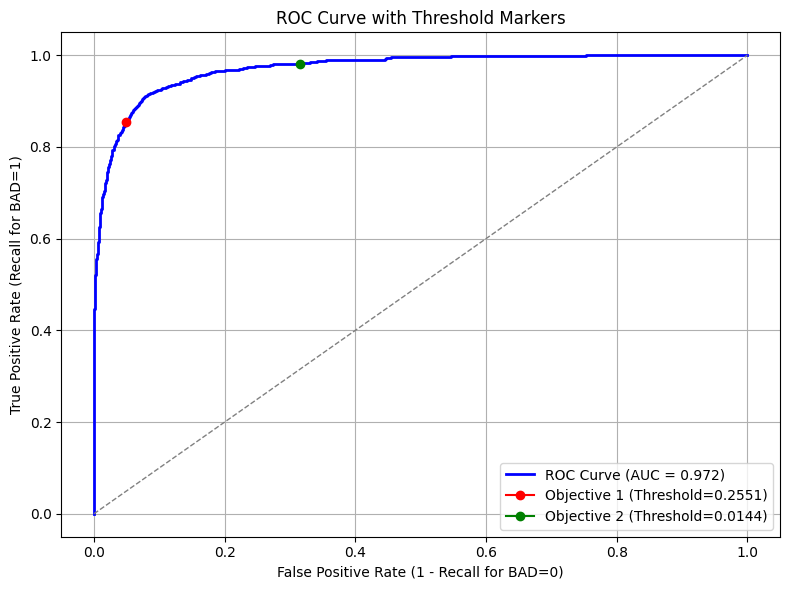

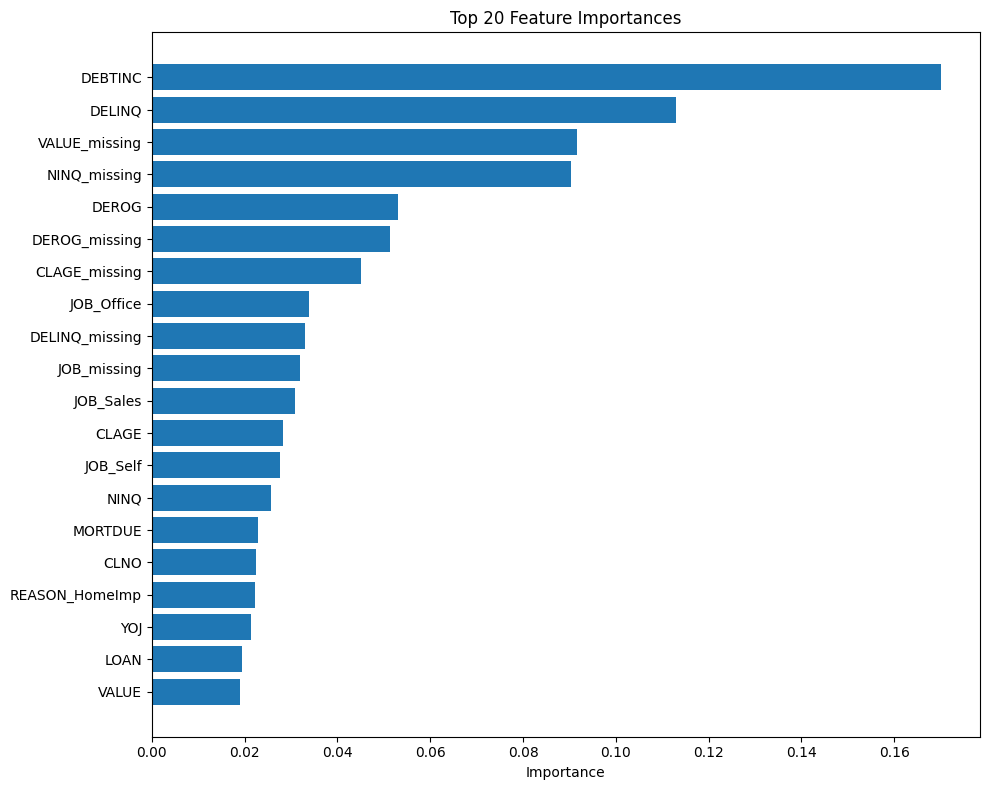

           Feature  Importance
9          DEBTINC    0.169994
5           DELINQ    0.112982
10   VALUE_missing    0.091553
16    NINQ_missing    0.090378
4            DEROG    0.053065
13   DEROG_missing    0.051388
15   CLAGE_missing    0.045120
18      JOB_Office    0.033949
14  DELINQ_missing    0.032919
11     JOB_missing    0.032028
21       JOB_Sales    0.030789
6            CLAGE    0.028291
22        JOB_Self    0.027673
7             NINQ    0.025680
1          MORTDUE    0.022920
8             CLNO    0.022539
17  REASON_HomeImp    0.022195
3              YOJ    0.021402
0             LOAN    0.019380
2            VALUE    0.019010
20     JOB_ProfExe    0.018501
12     YOJ_missing    0.017458
19       JOB_Other    0.010786


In [17]:
df = get_dataset()

xgb_model, xgb_thresh_1, xgb_thresh_2, xgb_probs, y_true_xgb = train_eval_model(df, "xgb")

## Random Forest

✅ Best Threshold for Objective 1:
      threshold  recall_bad  recall_good
3565     0.3575    0.850294     0.958709

Confusion Matrix (Objective 1):
[[4574  197]
 [ 178 1011]]

Classification Report (Objective 1):
              precision    recall  f1-score   support

           0      0.963     0.959     0.961      4771
           1      0.837     0.850     0.844      1189

    accuracy                          0.937      5960
   macro avg      0.900     0.905     0.902      5960
weighted avg      0.937     0.937     0.937      5960

----------------------------------------------------
✅ Best Threshold for Objective 2:
     threshold  recall_bad  recall_good
617     0.0627    0.993272     0.705722

Confusion Matrix (Objective 2):
[[3367 1404]
 [   8 1181]]

Classification Report (Objective 2):
              precision    recall  f1-score   support

           0      0.998     0.706     0.827      4771
           1      0.457     0.993     0.626      1189

    accuracy                  

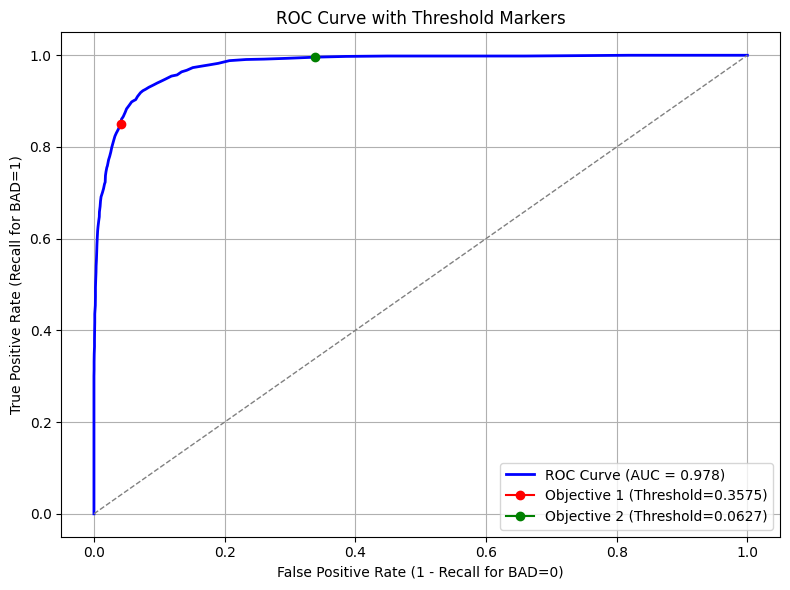

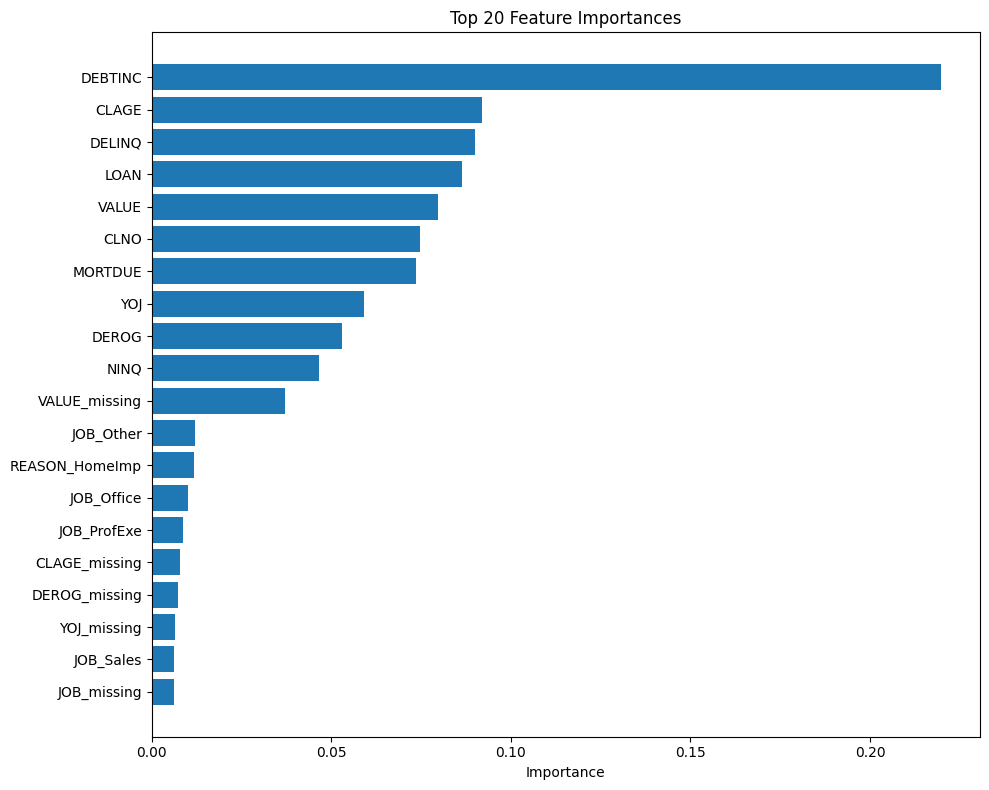

           Feature  Importance
9          DEBTINC    0.219668
6            CLAGE    0.091970
5           DELINQ    0.089877
0             LOAN    0.086274
2            VALUE    0.079564
8             CLNO    0.074684
1          MORTDUE    0.073664
3              YOJ    0.059032
4            DEROG    0.052932
7             NINQ    0.046528
10   VALUE_missing    0.037112
19       JOB_Other    0.011933
17  REASON_HomeImp    0.011752
18      JOB_Office    0.010188
20     JOB_ProfExe    0.008762
15   CLAGE_missing    0.007792
13   DEROG_missing    0.007388
12     YOJ_missing    0.006509
21       JOB_Sales    0.006166
11     JOB_missing    0.006139
22        JOB_Self    0.004284
16    NINQ_missing    0.004273
14  DELINQ_missing    0.003509


In [18]:
df = get_dataset()

rf_model, rf_thresh_1, rf_thresh_2, rf_probs, y_true_rf = train_eval_model(df, "rf")